In [1]:
#######################
### LOAD IN MODULES ###
#######################

import cv2 # to install on mac: pip install opencv-python
from scipy.interpolate import interp1d # for interpolating points
from sklearn.decomposition import PCA # for principal component analysis
from scipy.spatial import procrustes # for Procrustes analysis
from scipy.spatial import ConvexHull # for convex hull
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # for LDA
from sklearn.metrics import confusion_matrix # for confusion matrix
from os import listdir # for retrieving files from directory
from os.path import isfile, join # for retrieving files from directory
import matplotlib.pyplot as plt # for plotting
import numpy as np # for using arrays
import math # for mathematical operations
import pandas as pd # for using pandas dataframes
import seaborn as sns # for plotting in seaborn
from matplotlib.colors import LogNorm

In [2]:
#################
### FUNCTIONS ###
#################

def angle_between(p1, p2, p3):
    """
    define a function to find the angle between 3 points anti-clockwise in degrees, p2 being the vertex
    inputs: three angle points, as tuples
    output: angle in degrees
    """
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    deg1 = (360 + math.degrees(math.atan2(x1 - x2, y1 - y2))) % 360
    deg2 = (360 + math.degrees(math.atan2(x3 - x2, y3 - y2))) % 360
    return deg2 - deg1 if deg1 <= deg2 else 360 - (deg1 - deg2)

def rotate_points(xvals, yvals, degrees):
    """"
    define a function to rotate 2D x and y coordinate points around the origin
    inputs: x and y vals (can take pandas dataframe columns) and the degrees (positive, anticlockwise) to rotate
    outputs: rotated and y vals
    """
    angle_to_move = 90-degrees
    rads = np.deg2rad(angle_to_move)
    
    new_xvals = xvals*np.cos(rads)-yvals*np.sin(rads)
    new_yvals = xvals*np.sin(rads)+yvals*np.cos(rads)
    
    return new_xvals, new_yvals

def interpolation(x, y, number): 
    """
    define a function to return equally spaced, interpolated points for a given polyline
    inputs: arrays of x and y values for a polyline, number of points to interpolate
    ouputs: interpolated points along the polyline, inclusive of start and end points
    """
    distance = np.cumsum(np.sqrt( np.ediff1d(x, to_begin=0)**2 + np.ediff1d(y, to_begin=0)**2 ))
    distance = distance/distance[-1]

    fx, fy = interp1d( distance, x ), interp1d( distance, y )

    alpha = np.linspace(0, 1, number)
    x_regular, y_regular = fx(alpha), fy(alpha)
    
    return x_regular, y_regular

def euclid_dist(x1, y1, x2, y2):
    """
    define a function to return the euclidean distance between two points
    inputs: x and y values of the two points
    output: the eulidean distance
    """
    return np.sqrt((x2-x1)**2 + (y2-y1)**2)

def poly_area(x,y):
    """
    define a function to calculate the area of a polygon using the shoelace algorithm
    inputs: separate numpy arrays of x and y coordinate values
    outputs: the area of the polygon
    """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def gpa_mean(leaf_arr, landmark_num, dim_num):
    
    """
    define a function that given an array of landmark data returns the Generalized Procrustes Analysis mean
    inputs: a 3 dimensional array of samples by landmarks by coordinate values, number of landmarks, number of dimensions
    output: an array of the Generalized Procrustes Analysis mean shape
    
    """

    ref_ind = 0 # select arbitrary reference index to calculate procrustes distances to
    ref_shape = leaf_arr[ref_ind, :, :] # select the reference shape

    mean_diff = 10**(-30) # set a distance between means to stop the algorithm

    old_mean = ref_shape # for the first comparison between means, set old_mean to an arbitrary reference shape

    d = 1000000 # set d initially arbitraily high

    while d > mean_diff: # set boolean criterion for Procrustes distance between mean to stop calculations

        arr = np.zeros( ((len(leaf_arr)),landmark_num,dim_num) ) # empty 3D array: # samples, landmarks, coord vals

        for i in range(len(leaf_arr)): # for each leaf shape 

            s1, s2, distance = procrustes(old_mean, leaf_arr[i]) # calculate procrustes adjusted shape to ref for current leaf
            arr[i] = s2 # store procrustes adjusted shape to array

        new_mean = np.mean(arr, axis=(0)) # calculate mean of all shapes adjusted to reference

        s1, s2, d = procrustes(old_mean, new_mean) # calculate procrustes distance of new mean to old mean

        old_mean = new_mean # set the old_mean to the new_mea before beginning another iteration

    return new_mean


# Read in data

In [3]:
########################
### READ IN METADATA ###
########################

mdata = pd.read_csv("./coca_metadata.csv") # read in csv

mdata.head() # head data to check

,full_species,species,id,px_cm
0,cataractarum,cata,151,62.0
1,cataractarum,cata,1383,76.0
2,cataractarum,cata,1422,75.0
3,cataractarum,cata,2614,58.0
4,cataractarum,cata,3565,85.0


In [4]:
#######################################
### MAKE A LIST OF IMAGE FILE NAMES ###
#######################################

data_dir = "./all_wild_coca/" # set data directory

file_names = [f for f in listdir(data_dir) if isfile(join(data_dir, f))] # create a list of file names

file_names.remove('.DS_Store') # remove .DS_Store file

file_names.sort() # sort the list of file names

file_names # check list of file names

['cata_13277_1.txt',
 'cata_13277_2.txt',
 'cata_13277_3.txt',
 'cata_13277_4.txt',
 'cata_13277_5.txt',
 'cata_1383_1.txt',
 'cata_1383_2.txt',
 'cata_1383_3.txt',
 'cata_1383_5.txt',
 'cata_1422_2.txt',
 'cata_1422_3.txt',
 'cata_1422_4.txt',
 'cata_1422_5.txt',
 'cata_1422_6.txt',
 'cata_151_1.txt',
 'cata_151_2.txt',
 'cata_151_3.txt',
 'cata_151_4.txt',
 'cata_151_5.txt',
 'cata_1773994_1.txt',
 'cata_1773994_2.txt',
 'cata_1773994_3.txt',
 'cata_1773994_4.txt',
 'cata_2171745_1.txt',
 'cata_2171745_2.txt',
 'cata_2171745_3.txt',
 'cata_2171745_4.txt',
 'cata_2171746_1.txt',
 'cata_2171746_2.txt',
 'cata_2171746_3.txt',
 'cata_2171746_4.txt',
 'cata_2171746_5.txt',
 'cata_2253071_1.txt',
 'cata_2253071_2.txt',
 'cata_2253071_3.txt',
 'cata_2253071_4.txt',
 'cata_2253071_5.txt',
 'cata_2458022_1.txt',
 'cata_2458022_2.txt',
 'cata_2614_1.txt',
 'cata_2614_2.txt',
 'cata_2614_3.txt',
 'cata_2614_4.txt',
 'cata_2614_5.txt',
 'cata_2690426_1.txt',
 'cata_2690426_2.txt',
 'cata_2690426

# Process and landmark data

- Read in image in grayscale
- Select the contour of the largest object (the leaf)
- Interpolate with a high resolution of pseudo-landmarks
- Find the base and tip index point on the high resolution contour
- Reset the base index to zero
- Interpolate each side with desired number of equidistant pseudo-landmarks
- Rotate leaves and scale to centimeters
- Save pseudo-landmarks scaled to centimeters in an array

PARAMETERS AND INDEXING:
- `high_res_pts` is an arbitrarily high number of points to initially interpolate
- `res` is the desired number of points to interpolate on each side of the leaf
- The total number of pseudo-landmarks will be `2*res - 1`
- The base index will be `0`
- The tip index will be `res-1`
- The returned leaves in `cm_arr` are scaled in size to centimeters

In [5]:
######################
### SET PARAMETERS ###
######################

# the number of equidistant points to create
# an initial high resolution outline of the leaf
high_res_pts = 10000

# the percent length of the leaf to identify the tip and base
percent = 0.02

# the ultimate number of equidistant points on each side of the leaf
# (-1 for the tip)
# the leaf will have res*2-1 pseudo-landmarks
#################
#################
#################
res = 50 ########
#################
#################

# get species and herbarium id for each file
# get leaf area for each file
spe_list = [] # to store species identification
herb_id_list = [] # to store hebarium identification
cm_area_list = [] # to store the area in cm

# an array to store pseudo-landmarks
cm_arr = np.zeros((len(file_names),(res*2)-1,2))

for i in range(len(file_names)): # for each leaf
    
    #############################################
    ### READ IN DATA AND RETRIEVE INFORMATION ###
    #############################################

    name = file_names[i] # get current file name
    
    print(i, name) # print current file name for trouble shooting

    spe = name[:4] # get species name

    herb_id = name[5:-6] # get herbarium id

    lf_coords = np.loadtxt("./all_wild_coca/" + name) # load in leaf coordinates

    px_area = poly_area(lf_coords[:,0],lf_coords[:,1]) # calculate area in pixels

    mdata_spe = mdata[mdata["species"]==spe] # mask metadata by species
    mdata_id = mdata_spe[mdata_spe["id"]==herb_id] # mask metadata by herbarium id

    scale = float(mdata_id["px_cm"].iloc[0]) # retrieve the px per cm scale

    cm_area = px_area*(1/scale**2) # retrieve cm2 area
    
    spe_list.append(spe) # store species id
    herb_id_list.append(herb_id) # store herbarium id
    cm_area_list.append(cm_area) # store area in cm2
    
    ################################################
    ### ORIENT LEAF AND FIND BASE AND TIP POINTS ###
    ################################################
    
    pca = PCA(n_components=2) # perform PCA to align along longest axis
    pca = pca.fit_transform(lf_coords)

    left_side = pca[
        (pca[:,0])<
        np.min(pca[:,0])+((np.max(pca[:,0])-np.min(pca[:,0]))*percent)] # isolate left tip

    right_side = pca[
        (pca[:,0])>
        np.max(pca[:,0])-((np.max(pca[:,0])-np.min(pca[:,0]))*percent)] # isolate right tip

    left_height = np.abs(left_side[0,1]-left_side[-1,1]) # get left tip height

    right_height = np.abs(right_side[0,1]-right_side[-1,1]) # get right tip height

    if left_height>=right_height:
        bigger_tip=left_side
        smaller_tip=right_side
    else:
        bigger_tip=right_side
        smaller_tip=left_side

    base_pt = smaller_tip[np.abs(smaller_tip[:,0])==np.max(np.abs(smaller_tip[:,0]))][0]
    tip_pt = bigger_tip[np.abs(bigger_tip[:,0])==np.max(np.abs(bigger_tip[:,0]))][0]
    
    ################################################
    ### INTERPOLATE HIGH RES NUMBER OF LANDMARKS ###
    ################################################

    # convert the leaf to high resolution number of landmarks
    # using high_res_pt value
    # need to convert arrays of pixel int to floats first
    high_res_x, high_res_y = interpolation(pca[:,0], 
                                           pca[:,1], high_res_pts)
    
    ###############################
    ### FIND BASE AND TIP INDEX ###
    ###############################

    base_dists = [] # store distance of each high res point to base
    tip_dists = [] # store distance of each high res point to tip

    for pt in range(len(high_res_x)): # for each of the high resolution points

        # euclidean distance of the current point from the base and tip landmark
        ed_base = euclid_dist(base_pt[0], base_pt[1], high_res_x[pt], high_res_y[pt])
        ed_tip = euclid_dist(tip_pt[0], tip_pt[1], high_res_x[pt], high_res_y[pt])

        # store distance of current point from base/tip
        base_dists.append(ed_base)
        tip_dists.append(ed_tip)

    # get index of base and tip points
    base_ind = np.argmin(base_dists)
    tip_ind = np.argmin(tip_dists)
    
    ################################
    ### RESET BASE INDEX TO ZERO ###
    ################################

    # reset base index position to zero
    high_res_x = np.concatenate((high_res_x[base_ind:],high_res_x[:base_ind]))
    high_res_y = np.concatenate((high_res_y[base_ind:],high_res_y[:base_ind]))

    # recalculate indices with new indexing
    tip_ind = tip_ind-base_ind # note: negative index if tip_ind<base_ind
    base_ind = base_ind-base_ind

    # create single array for leaf coordinates
    lf_contour = np.column_stack((high_res_x, high_res_y))
    
    ##############################################################
    ### INTERPOLATE EACH SIDE WITH DESIRED NUMBER OF LANDMARKS ###
    ##############################################################

    # interpolate at desired resolution the left and right sides of the leaf
    left_inter_x, left_inter_y = interpolation(lf_contour[base_ind:tip_ind+1,0],lf_contour[base_ind:tip_ind+1,1],res)
    right_inter_x, right_inter_y = interpolation(lf_contour[tip_ind:,0],lf_contour[tip_ind:,1],res)

    # the start of the right side and end of the left side
    # both contain the tip landmark
    # delete the last point on the left side
    left_inter_x = np.delete(left_inter_x, -1)
    left_inter_y = np.delete(left_inter_y, -1)

    # BASE OF LEAF IS INDEX 0
    # TIP INDEX IS RES-1 IF BOTH LEFT & RIGHT POINTS
    # TOTAL PSEUDOLANDMARKS IS 2*RES-1
    lf_pts_left = np.column_stack((left_inter_x, left_inter_y))
    lf_pts_right = np.column_stack((right_inter_x, right_inter_y))
    lf_pts = np.row_stack((lf_pts_left, lf_pts_right))
    
    ##########################################################
    ### ROTATE LEAVES UPWARD AND SCALE SIZE TO CENTIMETERS ###
    ##########################################################

    tip_point = lf_pts[res-1,:] # get tip point
    base_point = lf_pts[0,:] # get base point

    # calculate angle between tip. base, and an arbitrary reference
    ang = angle_between(tip_point, base_point, (base_point[0]+1,base_point[1]) )

    # rotate points upwards
    rot_x, rot_y = rotate_points(lf_pts[:,0], lf_pts[:,1], ang) 
    rot_pts = np.column_stack((rot_x, rot_y))
    
    # calculate leaf area in pixels^2
    lf_area_px2 = poly_area(rot_pts[:,0], rot_pts[:,1])
    
    # get px_cm
    px_cm = np.sqrt(lf_area_px2/cm_area)

    # scale leaf into cm
    cm_lf = rot_pts/(px_cm)
    
    # store the leaf scaled into cm into the cm_arr
    cm_arr[i,:,:] = cm_lf


0 cata_13277_1.txt
1 cata_13277_2.txt
2 cata_13277_3.txt
3 cata_13277_4.txt
4 cata_13277_5.txt
5 cata_1383_1.txt
6 cata_1383_2.txt
7 cata_1383_3.txt
8 cata_1383_5.txt
9 cata_1422_2.txt
10 cata_1422_3.txt
11 cata_1422_4.txt
12 cata_1422_5.txt
13 cata_1422_6.txt
14 cata_151_1.txt
15 cata_151_2.txt
16 cata_151_3.txt
17 cata_151_4.txt
18 cata_151_5.txt
19 cata_1773994_1.txt
20 cata_1773994_2.txt
21 cata_1773994_3.txt
22 cata_1773994_4.txt
23 cata_2171745_1.txt
24 cata_2171745_2.txt
25 cata_2171745_3.txt
26 cata_2171745_4.txt
27 cata_2171746_1.txt
28 cata_2171746_2.txt
29 cata_2171746_3.txt
30 cata_2171746_4.txt
31 cata_2171746_5.txt
32 cata_2253071_1.txt
33 cata_2253071_2.txt
34 cata_2253071_3.txt
35 cata_2253071_4.txt
36 cata_2253071_5.txt
37 cata_2458022_1.txt
38 cata_2458022_2.txt
39 cata_2614_1.txt
40 cata_2614_2.txt
41 cata_2614_3.txt
42 cata_2614_4.txt
43 cata_2614_5.txt
44 cata_2690426_1.txt
45 cata_2690426_2.txt
46 cata_2690426_3.txt
47 cata_2690426_4.txt
48 cata_2690427_1.txt
49 c

364 grac_2345_1.txt
365 grac_2345_2.txt
366 grac_243_1.txt
367 grac_243_2.txt
368 grac_2573_1.txt
369 grac_2647_1.txt
370 grac_2647_2.txt
371 grac_2647_3.txt
372 grac_2647_4.txt
373 grac_2772840_1.txt
374 grac_2772840_2.txt
375 grac_2772840_3.txt
376 grac_2817844_1.txt
377 grac_2817844_2.txt
378 grac_2817863_1.txt
379 grac_2817863_2.txt
380 grac_2817863_3.txt
381 grac_2817863_4.txt
382 grac_2864560_1.txt
383 grac_2864560_2.txt
384 grac_291_1.txt
385 grac_291_2.txt
386 grac_291_3.txt
387 grac_291_4.txt
388 grac_3068_1.txt
389 grac_3068_2.txt
390 grac_3068_3.txt
391 grac_3146_2.txt
392 grac_3725_1.txt
393 grac_3725_2.txt
394 grac_3725_3.txt
395 grac_5947157_1.txt
396 grac_5947157_2.txt
397 grac_5947157_3.txt
398 grac_5947157_4.txt
399 grac_627635_1.txt
400 grac_627635_2.txt
401 grac_6326091_1.txt
402 grac_6326091_2.txt
403 grac_6471_1.txt
404 grac_6957_1.txt
405 grac_6957_2.txt
406 grac_6957_5.txt
407 grac_699762_1.txt
408 grac_7626_2.txt
409 grac_7626_3.txt
410 grac_ASU0032976_1.txt
411

# Check by plotting random leaves

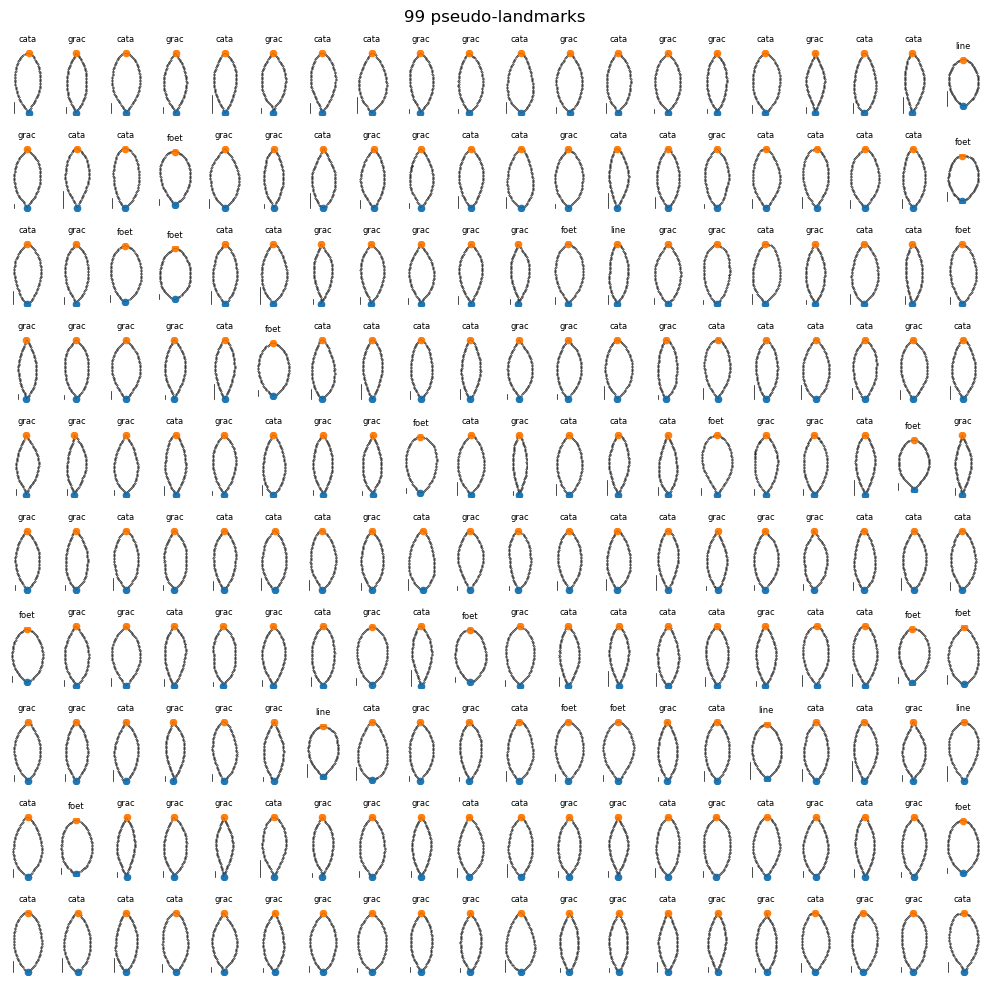

In [6]:
# Plot random leaves and check that it is working

plt.figure(figsize=(10,10)) # set figure size

rand_indices = np.random.randint(0,len(cm_arr),200) # generate random indices of leaves

plot_num = 1 # plot counter number

for i in rand_indices:
    
    plt.subplot(10,20,plot_num) # subplot number
    
    plt.plot(cm_arr[i,:,0], cm_arr[i,:,1], c="k", lw=0.1) # outline
    plt.plot([min(cm_arr[i,:,0])-0.1,min(cm_arr[i,:,0])-0.1],
            [cm_arr[i,0,1], cm_arr[i,0,1]+1], c="k", lw=0.5) # cm scale
    plt.scatter(cm_arr[i,:,0], cm_arr[i,:,1], c="k", s=0.1) # points
    plt.scatter(cm_arr[i,0,0], cm_arr[i,0,1], s=20) # base
    plt.scatter(cm_arr[i,res-1,0], cm_arr[i,res-1,1], s=20) # tip
    
    plt.title(spe_list[i], fontsize=6)
    
    plt.gca().set_aspect("equal")
    plt.axis("off")
    
    plot_num += 1
    
plt.suptitle(str(res*2-1) + " pseudo-landmarks")
plt.tight_layout()

# Analyze leaf dimensions

Using placed pseudo-landmarks representing leaves that are rotated upwards and scaled in centimeters from `cm_arr`, calculate the following:

- `width`: difference in centimeters between minimum and maximum x values in an oriented leaf
- `length`: difference in centimeters between minimum and maximum y values in an oriented leaf
- `area`: area of the leaf in centimeters squared
- `solidity`: the ratio of area to convex hull area
- `asymmetry`: the Procrustes distance between the superimposed left and right sides of a leaf outline. Lower values are more symmetric. Higher values are more asymmetric.  

Data is stored in the `mdata` dataframe.

In [7]:
# first, create a new metadata file
# we need the length to be the length of the leaves we analyzed

mdata = pd.DataFrame(
    {"species":spe_list,
    "herb_id":herb_id_list}
)

In [8]:
# lists to store variables
width_list = []
length_list = []
area_list = []
solidity_list = []
asymmetry_list = []

# for each leaf . . .
for lf in range(len(cm_arr)):
    
    # for calculating dimensions, we need non-scaled leaves in centimeters
    curr_lf = cm_arr[lf,:,:] # select current leaf
    
    ############################
    ### CALCULATE DIMENSIONS ###
    ############################
    
    width = np.max(curr_lf[:,0])-np.min(curr_lf[:,0]) # calculate width
    length = np.max(curr_lf[:,1])-np.min(curr_lf[:,1]) # calculate length
    area = poly_area(curr_lf[:,0],curr_lf[:,1]) # calcualte area
    
    ##########################
    ### CALCULATE SOLIDITY ###
    ##########################
    
    hull = ConvexHull(curr_lf) # calculate convex hull of current leaf
    vertices = hull.vertices # isolate vertex indices of convex hull
    convex_area = poly_area(curr_lf[vertices,0], curr_lf[vertices,1]) # calculate convex area
    solidity = area / convex_area # calculate solidity
    
    ##########################
    ### CALCULATE SYMMETRY ###
    ##########################
    
    left_side = curr_lf[:(res-1)+1,] # isolate left side of leaf
    right_side = curr_lf[(res-1):,] # isolate right side of leaf
    right_side = right_side[::-1] # reverse the right side to align indices with left

    # calculate procrustes distance between left and right side of leaf
    s1, s2, distance = procrustes(left_side, right_side) 
    
    # store data in lists
    width_list.append(width)
    length_list.append(length)
    area_list.append(area)
    solidity_list.append(solidity)
    asymmetry_list.append(distance)
    
# add data to the mdata dataframe
mdata["width"] = width_list
mdata["length"] = length_list
mdata["area"] = area_list
mdata["solidity"] = solidity_list
mdata["asymmetry"] = asymmetry_list
    

# Pair plots by types

/Users/chitwoo9/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


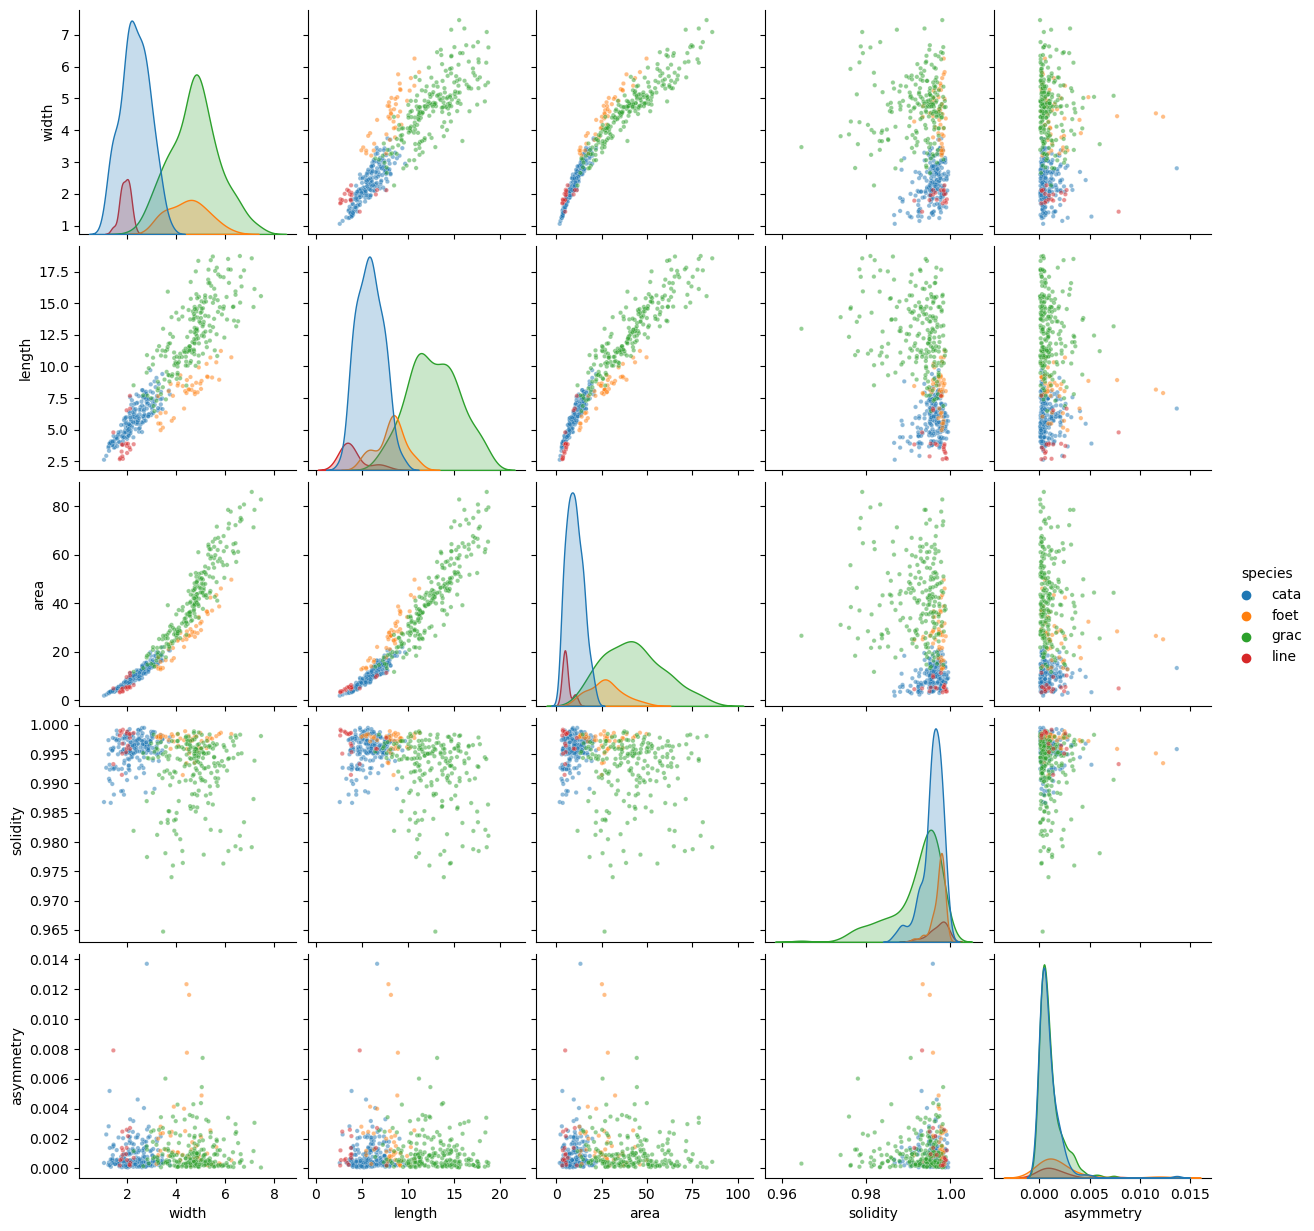

In [9]:
sns.pairplot(mdata,
             x_vars=["width", "length", "area","solidity","asymmetry"],
             y_vars=["width", "length", "area","solidity","asymmetry"],
             hue="species",
             plot_kws={"s": 10, "alpha":0.5, "lw":0}
            )


# Procrustes analysis

Perform a Procrustes analysis to translate, scale, and rotate leaf shapes

- Select number of pseudo-landmarks and dimensions
- Calculate the GPA mean leaf shape using the `gpa_mean` function
- Align all leaves to the GPA mean
- Store Procrustes super-imposed leaves in an array, `proc_arr`
- Calculate a PCA for all possible axes and their variance (the number of leaves)
- Calculate a PCA for just the axes needed for reconstruction of eigenleaves for morphospace (probably 2)

In [10]:
landmark_num = (res*2)-1 # select number of landmarks
dim_num = 2 # select number of coordinate value dimensions

##########################
### CALCULATE GPA MEAN ###
##########################

mean_shape = gpa_mean(cm_arr, landmark_num, dim_num)

################################
### ALIGN LEAVES TO GPA MEAN ###
################################

# array to store Procrustes aligned shapes
proc_arr = np.zeros(np.shape(cm_arr)) 

for i in range(len(cm_arr)):
    s1, s2, distance = procrustes(mean_shape, cm_arr[i,:,:]) # calculate procrustes adjusted shape to ref for current leaf
    proc_arr[i] = s2 # store procrustes adjusted shape to array
    

In [11]:
#################################################
### FIRST, CALCULATE PERCENT VARIANCE ALL PCs ###
#################################################

######
PC_NUMBER = 198 # PC number = not number of leaves, but features
#######

# use the reshape function to flatten to 2D
flat_arr = proc_arr.reshape(np.shape(proc_arr)[0], 
                                 np.shape(proc_arr)[1]*np.shape(proc_arr)[2]) 

pca_all = PCA(n_components=PC_NUMBER) 
PCs_all = pca_all.fit_transform(flat_arr) # fit a PCA for all data

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca_all.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca_all.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca_all.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )


PC: var, overall 
PC1: 82.2%, 82.2%
PC2: 6.5%, 88.7%
PC3: 3.9%, 92.6%
PC4: 2.1%, 94.7%
PC5: 1.6%, 96.3%
PC6: 0.9%, 97.2%
PC7: 0.6%, 97.7%
PC8: 0.4%, 98.1%
PC9: 0.3%, 98.4%
PC10: 0.3%, 98.7%
PC11: 0.2%, 98.9%
PC12: 0.1%, 99.0%
PC13: 0.1%, 99.2%
PC14: 0.1%, 99.3%
PC15: 0.1%, 99.3%
PC16: 0.1%, 99.4%
PC17: 0.1%, 99.5%
PC18: 0.1%, 99.5%
PC19: 0.0%, 99.5%
PC20: 0.0%, 99.6%
PC21: 0.0%, 99.6%
PC22: 0.0%, 99.6%
PC23: 0.0%, 99.7%
PC24: 0.0%, 99.7%
PC25: 0.0%, 99.7%
PC26: 0.0%, 99.7%
PC27: 0.0%, 99.7%
PC28: 0.0%, 99.8%
PC29: 0.0%, 99.8%
PC30: 0.0%, 99.8%
PC31: 0.0%, 99.8%
PC32: 0.0%, 99.8%
PC33: 0.0%, 99.8%
PC34: 0.0%, 99.8%
PC35: 0.0%, 99.8%
PC36: 0.0%, 99.8%
PC37: 0.0%, 99.8%
PC38: 0.0%, 99.8%
PC39: 0.0%, 99.9%
PC40: 0.0%, 99.9%
PC41: 0.0%, 99.9%
PC42: 0.0%, 99.9%
PC43: 0.0%, 99.9%
PC44: 0.0%, 99.9%
PC45: 0.0%, 99.9%
PC46: 0.0%, 99.9%
PC47: 0.0%, 99.9%
PC48: 0.0%, 99.9%
PC49: 0.0%, 99.9%
PC50: 0.0%, 99.9%
PC51: 0.0%, 99.9%
PC52: 0.0%, 99.9%
PC53: 0.0%, 99.9%
PC54: 0.0%, 99.9%
PC55: 0.0%, 99.9%


In [12]:
#################################################
### NEXT, CALCULATE THE DESIRED NUMBER OF PCs ###
#################################################

######
PC_NUMBER = 2 # keep to 2 for now for reconstruction
#######

pca = PCA(n_components=PC_NUMBER) 
PCs = pca.fit_transform(flat_arr) # fit a PCA for only desired PCs

# print out explained variance for each PC
print("PC: " + "var, " + "overall ") 
for i in range(len(pca.explained_variance_ratio_)):
    print("PC" + str(i+1) + ": " + str(round(pca.explained_variance_ratio_[i]*100,1)) + 
          "%, " + str(round(pca.explained_variance_ratio_.cumsum()[i]*100,1)) + "%"  )
    
# add PCs to dataframe for plotting
mdata["PC1"] = PCs[:,0]
mdata["PC2"] = PCs[:,1]
    

PC: var, overall 
PC1: 82.2%, 82.2%
PC2: 6.5%, 88.7%


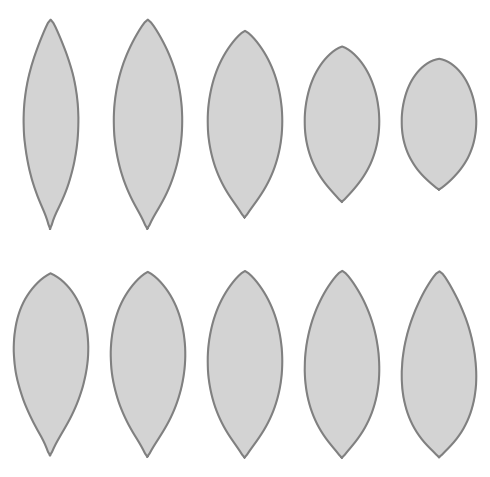

In [13]:
###################################################
### CREATE EIGEN REPRESENTATIONS OF FIRST 2 PCs ###
###################################################

# calculate standard deviations for each PC
PC1_std = mdata["PC1"].std()
PC2_std = mdata["PC2"].std()

# create list of lists of PC values to reconstruct
PC_vals = [[-2*PC1_std,0],
           [-1*PC1_std,0],
           [0*PC1_std,0],
           [1*PC1_std,0],
           [2*PC1_std,0],
           [0,-2*PC2_std],
           [0,-1*PC2_std],
           [0,0*PC2_std],
           [0,1*PC2_std],
           [0,2*PC2_std],
]

plt.figure(figsize=(5,5))

counter = 1

for i in range(len(PC_vals)):
    
    # create inverse leaf
    inv_leaf = pca.inverse_transform(np.array(PC_vals[i]))
    inv_x = inv_leaf[0::2] # select just inverse x vals
    inv_y = inv_leaf[1::2] # select just inverse y vals
    
    # plot inverse leaf
    plt.subplot(2,5,counter)
    plt.fill(inv_x, inv_y, c="lightgray")
    plt.plot(inv_x, inv_y, c="gray")
    plt.gca().set_aspect("equal")
    plt.axis("off")
    
    counter += 1

plt.tight_layout()

# Morphospace and Linear Discriminant Analysis by genotype

Visualize a morphospace and classify leaves by the factor of genotype

- Plot a morphospace using the inverse transform of the PCA
- Perform a Linear Discriminant Analysis
- Visualize LDA results as a confusion matrix
- Plot out LDA scores
- Note: the number of LDs is 1 minus the number of factor levels. In this example there are two genotypes, so there is only 1 LD
- Note: the column names to plot the Linear Discriminants are manually renamed

Text(0.5, 1.0, 'Procrustean morphospace')

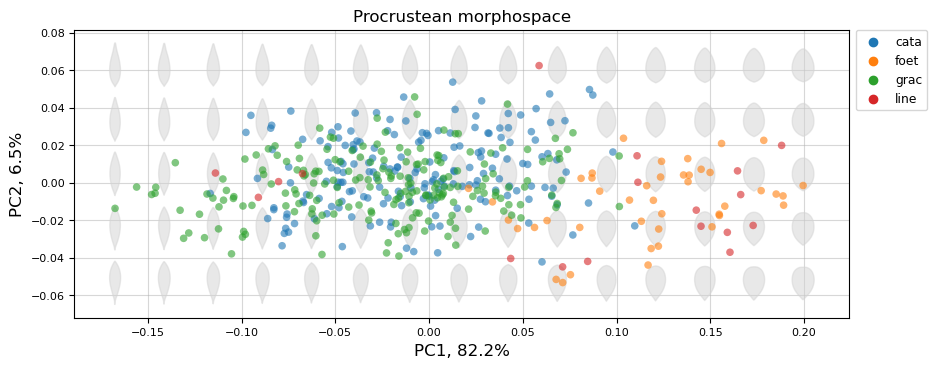

In [14]:
##########################
### CREATE MORPHOSPACE ###
##########################

# set plot parameters

plot_length= 10 # plot length in inches
plot_width= 10 # plot length in inches
numPC1 = 15 # set number of PC1 intervals
numPC2 = 5 # set number of PC2 intervals
hue = "species" # select the factor to color by
s = 0.07 # set the scale of the eigenleaves
lf_col = "lightgray" # color of inverse eigenleaf
lf_alpha = 0.5 # alpha of inverse eigenleaf
pt_size = 30 # size of data points
pt_linewidth = 0 # lw of data points, set to 0 for no edges
pt_alpha = 0.6 # alpha of the data points
ax_label_fs = 12 # font size of the x and y axis titles
ax_tick_fs = 8 # font size of the axis ticks
face_col = "white" # color of the plot background
grid_alpha = 0.5 # set the alpha of the grid
title = "Procrustean morphospace" # set title

plt.figure(figsize=(plot_length, plot_width))

PC1_vals = np.linspace( np.min(PCs[:,0]), np.max(PCs[:,0]), numPC1 ) # create PC intervals
PC2_vals = np.linspace( np.min(PCs[:,1]), np.max(PCs[:,1]), numPC2 )

for i in PC1_vals: # for each PC1 interval
    for j in PC2_vals: # for each PC2 interval
        
        pc1_val = i # select the current PC1 val
        pc2_val = j # select the current PC2 val

        # calculate the inverse eigenleaf
        inv_leaf = pca.inverse_transform(np.array([pc1_val,pc2_val]))
        inv_x = inv_leaf[0::2] # select just inverse x vals
        inv_y = inv_leaf[1::2] # select just inverse y vals
        
        # plot the inverse eigenleaf
        plt.fill(inv_x*s+pc1_val, inv_y*s+pc2_val, c=lf_col, alpha=lf_alpha)
   
# plot the data on top of the morphospace
sns.scatterplot(data=mdata, x="PC1", y="PC2", hue=hue, s=pt_size, linewidth=pt_linewidth, alpha=pt_alpha)

plt.legend(bbox_to_anchor=(1.00, 1.02), prop={'size': 8.9})
xlab = "PC1, " + str(round(pca.explained_variance_ratio_[0]*100,1)) + "%"
ylab = "PC2, " + str(round(pca.explained_variance_ratio_[1]*100,1)) + "%"
plt.xlabel(xlab, fontsize=ax_label_fs)
plt.ylabel(ylab, fontsize=ax_label_fs)
plt.xticks(fontsize=ax_tick_fs)
plt.yticks(fontsize=ax_tick_fs)
plt.gca().set_aspect("equal")
plt.gca().set_facecolor(face_col)
plt.grid(alpha=grid_alpha)
plt.gca().set_axisbelow(True)
plt.title(title)

The number of falsely predicted: 4
The number of correctly predicted: 446
Out of 450 total samples


Text(98.22222222222221, 0.5, 'Actual class')

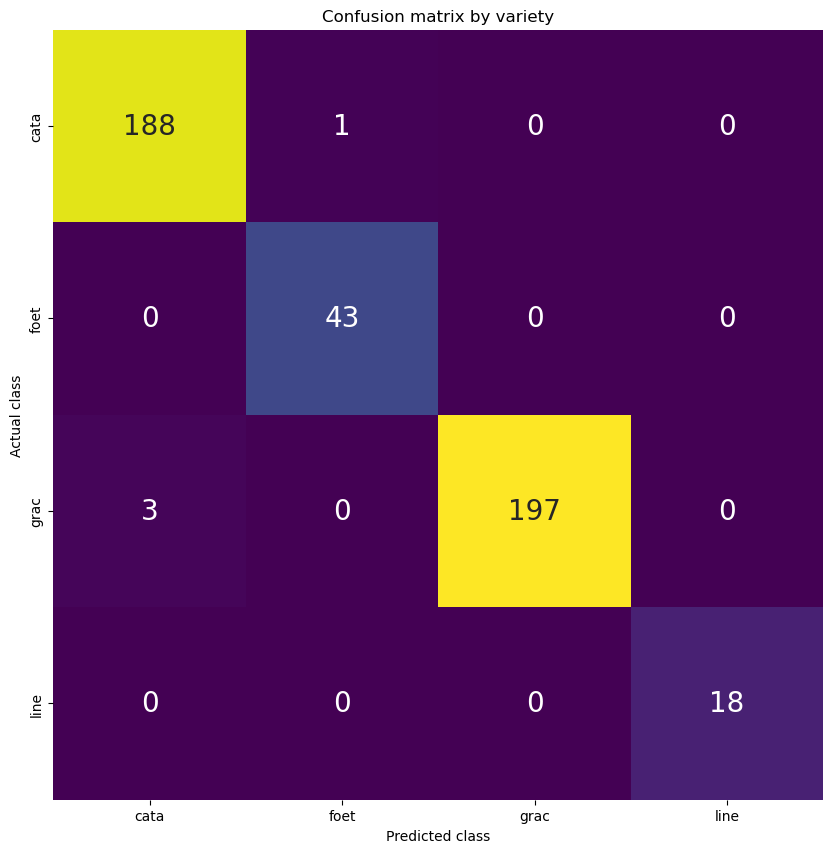

In [15]:
##################################################
### PERFORM LINEAR DISCRIMINANT ANALYSIS (LDA) ###
##################################################

# create a df for LDA by species
species_df = pd.DataFrame(data=flat_arr[:,:])

# add the species labels
species_df["species"] = mdata["species"]

# create input and output variables
X = species_df.iloc[:,0:((res*2)-1)*2]
y = species_df["species"]

# fit the LDA model
species_model = LinearDiscriminantAnalysis()
species_model.fit(X,y)

# retrieve LDA scalings and coefficients
species_scalings = species_model.scalings_
species_coefs = species_model.coef_

# perform prediction
species_prediction = species_model.predict(X)
comparison_result = [X == y for X, y in zip(y, species_prediction)]

# print out number of correctly predicted results
count_true_pl = comparison_result.count(True)
count_false_pl = comparison_result.count(False)
print("The number of falsely predicted:", count_false_pl)
print("The number of correctly predicted:", count_true_pl)
print("Out of " + str(len(comparison_result)) + " total samples" )

# Create confusion matrix
true_species_values = mdata["species"]
predicted_species_values = species_prediction

cm_species = confusion_matrix(true_species_values, predicted_species_values)

classes = np.sort(mdata["species"].unique())

# Confusion matrix

plt.figure(figsize=(10,10))

sns.heatmap(cm_species, 
            annot=True, 
            annot_kws={"fontsize":20}, 
            fmt="d", 
            cmap="viridis", 
            square=True, 
            cbar=False,
            xticklabels=classes,
            yticklabels=classes,
            #norm=LogNorm()
           )
plt.title("Confusion matrix by variety")
plt.xlabel("Predicted class")
plt.ylabel("Actual class")



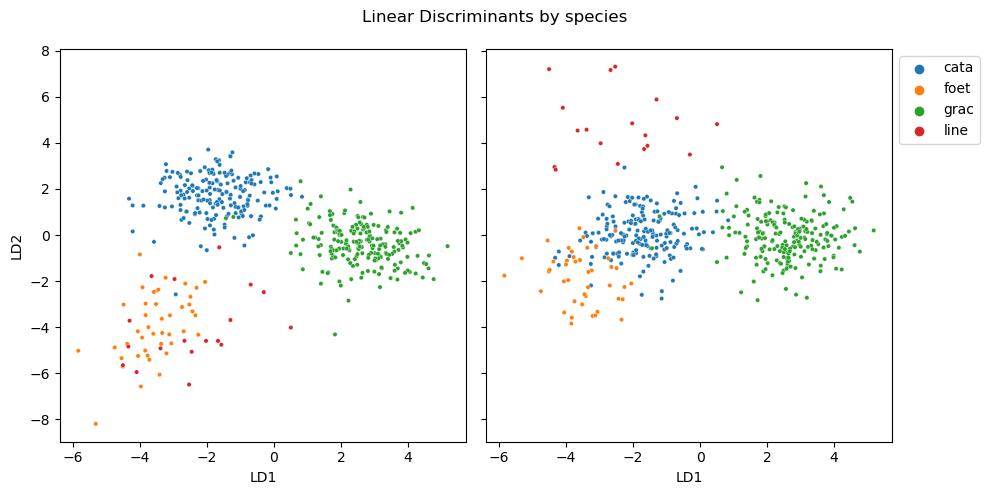

In [16]:
# Plot of linear discriminant scores by variety

data_plot = species_model.fit(X, y).transform(X)
species_plot_df = pd.DataFrame(data=data_plot[:,:])
species_plot_df["species"] = mdata["species"]

species_plot_df = species_plot_df.rename(columns={0:'LD1', 1:'LD2', 2:"LD3"})

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,5))

sns.scatterplot(data=species_plot_df, x="LD1", y="LD2", hue="species", s=10, ax=ax1)
ax1.get_legend().remove()
sns.scatterplot(data=species_plot_df, x="LD1", y="LD3", hue="species", s=10, ax=ax2)
ax2.get_legend().remove()
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.suptitle("Linear Discriminants by species")

plt.tight_layout()
